In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
from tensorflow.contrib.layers import conv2d, conv2d_transpose, max_pool2d
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import bokeh
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import DataSet
n_z = 2
n_epoch = 1
batchsize = 128
filepath = "/home/yunfanz/data/part3.tfrecords"
#filepath = "/home/yunfanz/data/part3.tfrecords"
container = DataSet(filepath, batchsize, train_frac=0.8)
STEPS_PER_EPOC = container.train_size // batchsize

image, label = container.get_next("train")
image_t, label_t = container.get_next("test")
num_sample = container.train_size
input_dim = 16*128
w = 128
h = 16
datasess = tf.Session()

W1006 21:12:04.762339 140378349745984 deprecation.py:323] From /home/yunfanz/Projects/spectral_represent/dataset.py:34: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
W1006 21:12:35.396310 140378349745984 deprecation_wrapper.py:119] From /home/yunfanz/Projects/spectral_represent/dataset.py:9: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.

W1006 21:12:35.405610 140378349745984 deprecation.py:323] From /home/yunfanz/Projects/spectral_represent/dataset.py:47: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.

Create dataset of size 4718851


In [3]:
label_replace = np.arange(343)
label_replace[199] = 198
datasess.run(container.test_iterator.initializer)
d, lab = datasess.run([image, label])
d_, lab_ = datasess.run([image_t, label_t])
# test_data, test_labels= [], []
# while True:
#     try:
#         d, lab = datasess.run([image_t, label_t])
#         test_data.append(d)
#         test_labels.append(lab)
#     except tf.errors.OutOfRangeError:
#         test_data = np.vstack(test_data)
#         test_labels = np.concatenate(test_labels, axis=0)
#         break

# datasess.run(container.test_iterator.initializer)

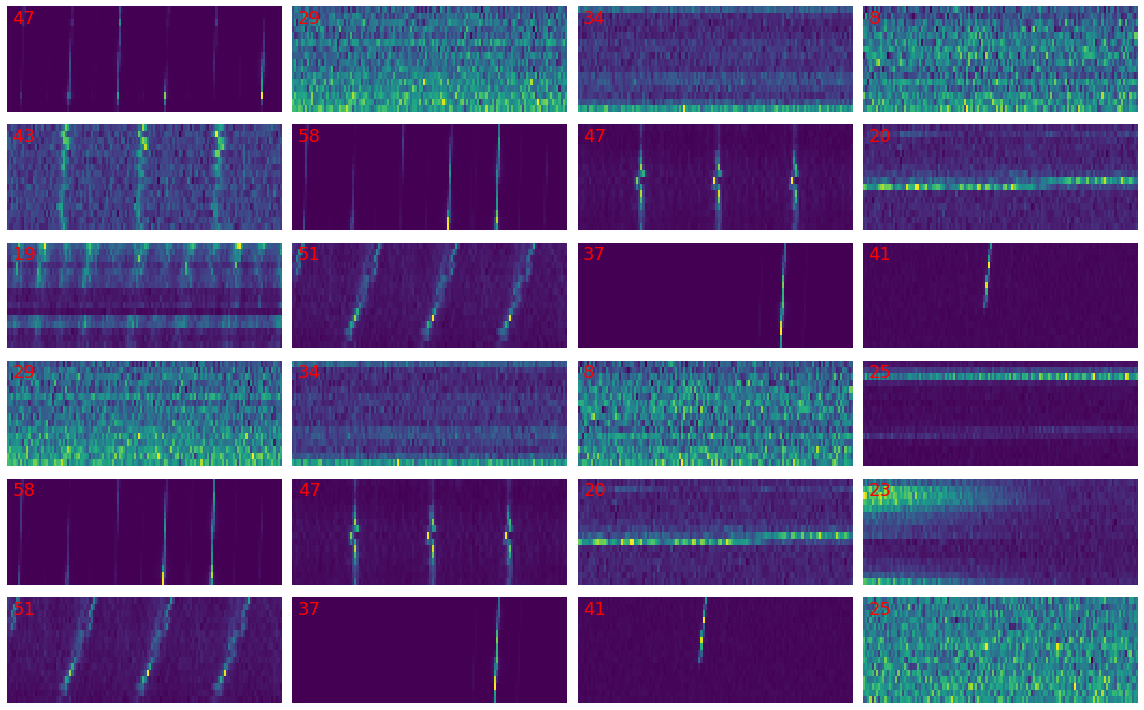

In [4]:
f, ax = plt.subplots(6,4, figsize=(16,10))
choices = np.random.randint(low=0, high=64, size=24)
for i in range(6):
    for j in range(4):
        ax[i,j].imshow(d[choices[j*3+i]].squeeze(), aspect='auto')
        ax[i,j].text(2,2,str(lab[choices[j*3+i]]), color='r', fontsize=18)
        ax[i,j].axis('off')
plt.tight_layout()
#plt.savefig('/home/yunfanz/Projects/presentations/random_signals.jpg')
plt.show()

In [8]:
from triplet_loss import *
class Autoencoder(object):

    def __init__(self, sess=None, input_dim=16*128, norm_type='minmax',
                 learning_rate=1e-4, n_z=16, loss_type='l2', use_conv=False):
        self.learning_rate = learning_rate
        self.n_z = n_z
        self.input_dim = input_dim
        tf.reset_default_graph()
        if sess is None:
            self.sess = tf.Session()
        else:
            self.sess = sess
        self.loss_type = loss_type
        self.norm_type = norm_type
        self.build(use_conv=use_conv)
        self.saver = tf.train.Saver(var_list=tf.trainable_variables())
        self.sess.run(tf.global_variables_initializer())

    def preprocess(self, input_raw):
        if self.norm_type == 'log':
            self.input_p = tf.log(tf.clip_by_value(self.input_raw, 1, 2900))
            self.recon_target = tf.cast(self.input_p, tf.int8, name='x')
        elif self.norm_type == 'minmax':
            self.input_p1 = input_raw - tf.reduce_min(input_raw, axis=(2,3), keepdims=True)
            self.input_p = self.input_p1 / tf.reduce_max(self.input_p1, axis=(2,3), keepdims=True)
            self.recon_target = self.input_p#tf.layers.flatten(self.input_p, name='x')
        elif self.norm_type == 'max':
            self.input_p = input_raw / tf.reduce_max(input_raw, axis=(2,3), keepdims=True)
            self.recon_target = self.input_p#tf.layers.flatten(self.input_raw, name='x')
        elif self.norm_type == 'std':
            mean = tf.reduce_mean(input_raw, axis=(2,3), keepdims=True)
            var = tf.reduce_mean(input_raw**2, axis=(2,3), keepdims=True) - mean**2
            self.input_p = tf.math.divide(input_raw - mean, tf.sqrt(var))
            self.recon_target = input_raw#tf.layers.flatten(self.input_raw, name='x')
        else:
            self.input_p = input_raw
            self.recon_target = input_raw
        return
            
    # Build the netowrk and the loss functions
    def build(self, loss_type='CE', use_conv=False, sphere_lat=True):
        self.input = tf.placeholder(
            dtype=tf.float32, shape=[None, h, w, 1], name="input_")
        self.label = tf.placeholder(dtype=tf.int32, shape=[None,], name="label_")
        self.preprocess(self.input)

        # Encode
        # x -> z_mean, z_sigma -> z
        if use_conv:
            f1 = conv2d(self.input, num_outputs=32, kernel_size=[3,3])
            m1 = max_pool2d(f1, kernel_size=[1,2], stride=[1,2])
            f2 = conv2d(m1, num_outputs=64, kernel_size=[3,3])
            m2 = max_pool2d(f2, kernel_size=2, stride=2)
            f3 = conv2d(m2, num_outputs=128, kernel_size=[3,3])
            m3 = max_pool2d(f3, kernel_size=[1,2], stride=[1,2])
            f4 = conv2d(m3, num_outputs=128, kernel_size=[3,3])
            m4 = max_pool2d(f4, kernel_size=2, stride=2)
            f5 = conv2d(m4, num_outputs=256, kernel_size=[3,3])
            m5 = max_pool2d(f5, kernel_size=2, stride=2)
            f6 = conv2d(m5, num_outputs=512, kernel_size=[3,3])
            #m6 = max_pool2d(f6, kernel_size=2, stride=2)
            #f7 = conv2d(m5, num_outputs=256, kernel_size=[3,3])
            ff = tf.reduce_mean(f6, axis=(1,2))
        else:
            self.x = tf.layers.flatten(self.input, name='x')
            f1 = fc(self.x, 512, scope='enc_fc1', activation_fn=tf.nn.relu)
            f2 = fc(f1, 256, scope='enc_fc2', activation_fn=tf.nn.relu)
            ff = fc(f2, 128, scope='enc_fc3', activation_fn=tf.nn.relu)
        z = fc(ff, self.n_z, scope='enc_fc4', activation_fn=None)
        if sphere_lat:
            norm = tf.sqrt(tf.reduce_sum(z*z,1, keepdims=True))
            self.z = tf.div(z, norm, name='enc_norm')
        else:
            self.z = z

        zloss, pos_frac = batch_all_triplet_loss(self.label, self.z, margin=0.1, squared=False) 
        zloss = zloss * 5.
        #tf.constant(0, dtype=tf.float32)
            
        # Decode
        # z -> x_hat
        if not use_conv:
            g1 = fc(self.z, 128, scope='dec_fc1', activation_fn=tf.nn.relu)
            g2 = fc(g1, 256, scope='dec_fc2', activation_fn=tf.nn.relu)
            g3 = fc(g2, 512, scope='dec_fc3', activation_fn=tf.nn.relu)
            self.x_hat = fc(g3, self.input_dim, scope='dec_fc4', 
                            activation_fn=tf.sigmoid)
        else:
            g1 = conv2d_transpose(m5, 64, kernel_size=[3,3], stride=[2,2], scope='dec_1', activation_fn=tf.nn.relu)
            g1_ = conv2d_transpose(g1, 64, kernel_size=[3,3],stride=[1,2], scope='dec_1_', activation_fn=tf.nn.relu)
            g2 = conv2d_transpose(g1_, 32, kernel_size=[3,3],stride=[2,2], scope='dec_2', activation_fn=tf.nn.relu)
            g2_ = conv2d_transpose(g2, 32, kernel_size=[3,3],stride=[1,2], scope='dec_2_', activation_fn=tf.nn.relu)
            self.x_hat = conv2d_transpose(g2_, 1, kernel_size=[3,3], stride=[2,2],activation_fn=tf.nn.sigmoid)
            self.recon_target = self.x

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        if self.loss_type == 'CE':
            self.recon_loss = -tf.reduce_sum(
                self.recon_target * tf.log(epsilon+self.x_hat) + 
                (1-self.recon_target) * tf.log(epsilon+1-self.x_hat), 
                axis=1
            )
        elif self.loss_type == 'l2':
            self.recon_loss = tf.sqrt(tf.reduce_mean(
                tf.square(self.recon_target -self.x_hat),
                axis=1
            ))
        elif self.loss_type == 'l1':
            self.recon_loss = tf.reduce_mean(
                tf.abs(self.recon_target -self.x_hat),
                axis=1
            ) * 3.
#         self.target_loss = -tf.reduce_sum(
#             self.x * tf.log(epsilon+self.x) + 
#             (1-self.x) * tf.log(epsilon+1-self.x), 
#             axis=1
#         )
        recon_loss = tf.reduce_mean(self.recon_loss) 

        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(recon_loss+zloss)
        
        self.losses = {
            'recon_loss': recon_loss,
            'zloss': zloss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self,x, label):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.input: x, self.label: label}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat, loss = self.sess.run([self.x_hat,self.recon_loss], feed_dict={self.input: x})
        return x_hat, loss
    
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.input: x})
        return z    

    def save_weights(self, path=".models/model.ckpt"):
        self.saver.save(self.sess, path)
        
    def load_weights(self, path=".models/model.ckpt"):
        self.saver.restore(self.sess, path)
        
    def show_vars(self):
        for var in tf.global_variables():
            print(var.name, var.get_shape())


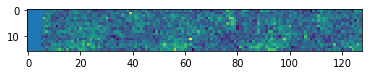

In [17]:
plt.hist(d[0].flatten(), bins=20)
plt.imshow(d[0].squeeze())

In [13]:
def add_noise(imgs, db=-10, per_image=False):
    """add noise assuming original noise is N(0,1),
    Thus originally noise is 0 dB. """
    amp = 10**(db/10)
    noise = np.random.normal(scale=amp, size=imgs.shape)
    if per_image:
        noise *= np.random.uniform(0,1, size=noise.shape[0])[:, np.newaxis, np.newaxis, np.newaxis]
    imgs += noise
    imgs /= np.sqrt(amp**2 + 1)
    return imgs

def trainer(model, input_tensor, label_tensor, with_noise, 
            batch_size=128, num_epoch=10, 
            log_step=5, val_step=1, bench_model=None):
    
    validation_hist = []

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = datasess.run([input_tensor, label_tensor])
            
            if with_noise:
                batch[0] = add_noise(batch[0], per_image=True)
            # Execute the forward and backward pass 
            # Report computed losses
            batch_lab = label_replace[batch[1]]
            losses = model.run_single_step(batch[0], batch_lab)
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
        if epoch % val_step == 0 and bench_model is not None:
            val_loss, comp_dist, comp_dist_ = validate(model, bench_model, image_t)
            validation_hist.append(val_loss)
            print("Validation Loss: ", val_loss)
            
    print('Done!')
    return model

def evaluate(zz, zz_, eval_size=1000):
    """
        zz: from model to be evaluated
        zz_: bench mark model
    """
    ztest = zz[:eval_size]
    zdist = np.sum(ztest[:, np.newaxis, :]* zz[np.newaxis, ...], axis=-1)
    ztest_ = zz_[:eval_size]
    zdist_ = np.sum(ztest_[:, np.newaxis, :]* zz_[np.newaxis, ...], axis=-1)
    
    zrank = np.argsort(zdist, axis=-1)[:,::-1]   #ranking by model
    zrank_ = np.argsort(zdist_, axis=-1)[:,::-1]   #ranking by benchmark
    comp_dist = np.asarray([zdist_[i][zrank[i]] for i in range(eval_size)])
    comp_dist_ = np.asarray([zdist_[i][zrank_[i]] for i in range(eval_size)])
    return comp_dist, comp_dist_
    
    
def validate(model, model_, data, db=0, cutoff=200, nbatch=8):
    if type(data) is np.ndarray:
        batch = data
    else:
        batch = []
        for i in range(nbatch):
            batch.append(datasess.run(data))
        batch = np.concatenate(batch, axis=0)
    zz_ = model_.transformer(batch)
    batch = add_noise(batch.copy(), db)
    zz = model.transformer(batch)
    
    comp_dist, comp_dist_ = evaluate(zz, zz_, eval_size=min(1000, batch.shape[0]))
    comp_dist = comp_dist[:,:cutoff]
    comp_dist_ = comp_dist_[:,:cutoff]
    loss = np.mean(np.sum((comp_dist - comp_dist_)**2, axis=1), axis=0) 
    return loss, comp_dist, comp_dist_
    

In [14]:
#load model
#model_ = Autoencoder(n_z=32, loss_type='l2', use_conv=True)
#model_.load_weights("./models/new_model/model.ckpt")
model = Autoencoder(sess=None, 
                     loss_type='l1', 
                     use_conv=False,
                     norm_type='minmax',
                     n_z=32,
                     learning_rate=1.e-4)
model_ = Autoencoder(sess=None, 
                     loss_type='l1', 
                     use_conv=False,
                     norm_type='minmax',
                     n_z=32,
                     learning_rate=1.e-4)

In [15]:
# Train a new model
model_ = trainer(model_,
                 image, label, 
                 num_epoch=10, 
                 log_step=1,
                 with_noise=False, 
                 bench_model=None)

model = trainer(model,
                 image, label, 
                 num_epoch=10, 
                 log_step=1,
                 with_noise=False, 
                 bench_model=model_)

KeyboardInterrupt: 

In [ ]:
loss, comp_dist, comp_dist_ = validate(model, model_, image_t)
f, ax = plt.subplots(2,1, figsize=(10,10))
for i in range(2):
    for j in range(1):
        k = i*2+j
        ax[i].plot(comp_dist[k])
        ax[i].plot(comp_dist_[k])
        if j == 0:
            ax[i].set_ylabel('distance')
#plt.savefig('/home/yunfanz/Projects/presentations/top5-eval.jpg')
plt.show()

In [40]:
embeddings = []
batch_id= 0
datasess.run(container.test_iterator.initializer)
while True:
    try:
        d, lab = datasess.run([image_t, label_t])
        emb = model_.transformer(d)
        embeddings.append(emb)
        batch_id += 1
        if batch_id % 1000 == 0:
            print(batch_id)
    except tf.errors.OutOfRangeError:
        embeddings = np.vstack(embeddings)
        break

1000


In [59]:
import os
os.makedirs("./models/new_model/")
model.save_weights("./models/new_model/model.ckpt")

In [62]:
def test_reconstruction(model, input_tensor, h=16, w=128, batch_size=128, n=4, m=4):
    # Test the trained model: reconstruction
    batch = datasess.run(input_tensor)
    x_reconstructed, losses = model.reconstructor(batch)
    #n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((2*h*n, w*m))
    for i in range(n):
        #print(losses[i*n:(i+1)*n])
        for j in range(m):
            orig = batch[i*n+j, :].reshape(h, w)
            orig -= np.amin(orig)
            orig /= np.amax(orig)
            #orig *= 0
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 orig),
                axis=0
            )
            x /= np.amax(x)
            I_reconstructed[2*i*h:2*(i+1)*h, j*w:(j+1)*w] = x
    f, ax = plt.subplots(figsize=(16, 16))
    f.set_tight_layout(True)
    p = ax.imshow(I_reconstructed, aspect='auto')
    f.colorbar(p, ax=ax)
    return losses, f

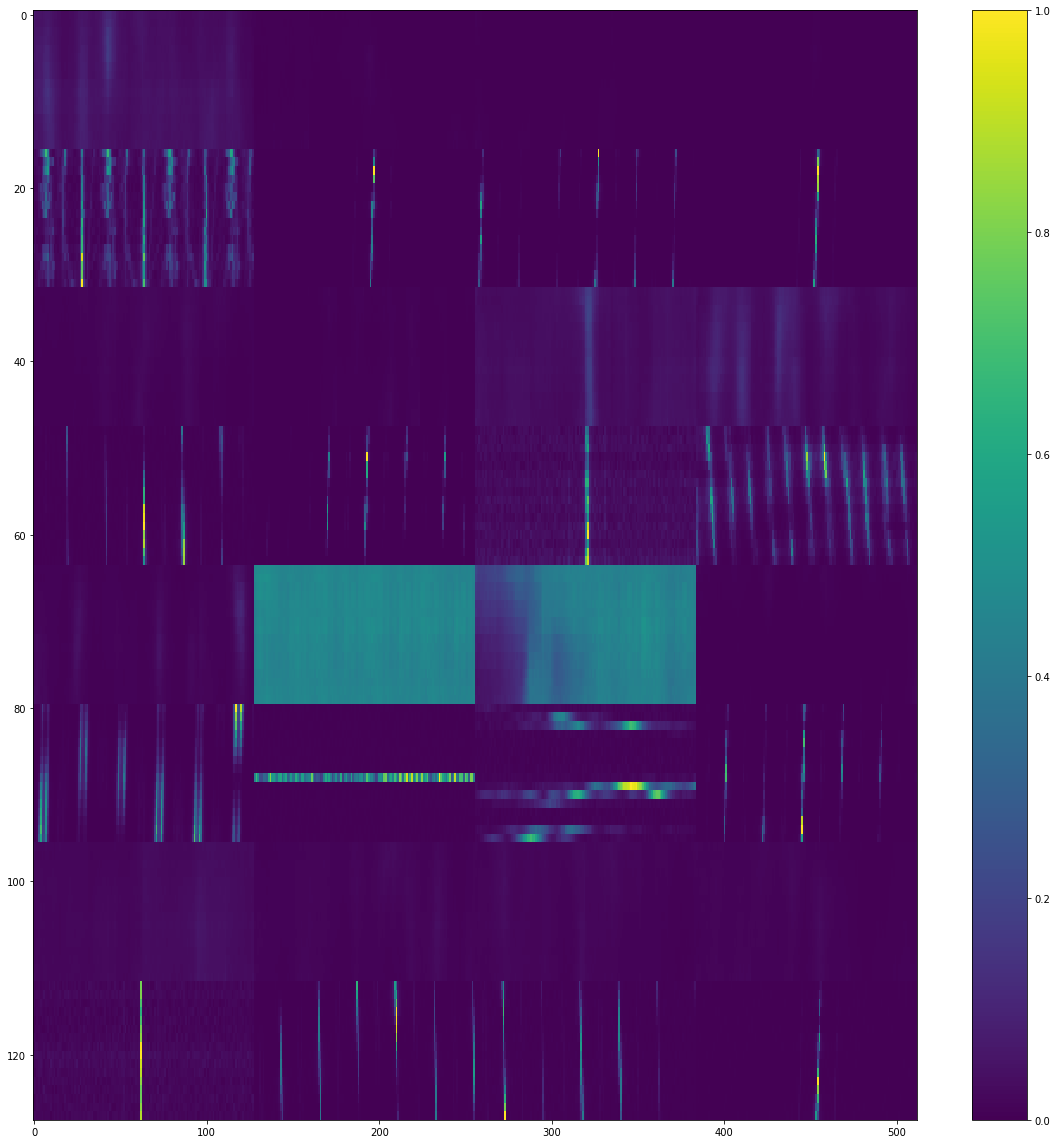

In [68]:
losses, f = test_reconstruction(model_, image, w=128)


In [53]:
def get_input(image, label, nbatch=16):
    images = []
    labels= []
    for i in range(nbatch):
        
        try:
            image_batch, label_batch = datasess.run([image,label])
        except tf.errors.OutOfRangeError:
            break
        images.append(image_batch)
        labels.append(label_batch)
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    return images, labels
def test_transformation(model_2d, images, c, noise=-1, return_images=False, plot=False):
    # Test the trained model: transformation
    #assert model_2d.n_z == 2
    if noise > 0:
        images = add_noise(images, noise)  #adding noise !!!

    z = model_2d.transformer(images)
    z_ = z
    if z_.shape[1] > 2:
        tsne = TSNE(n_components=2, random_state=214853)
        z = tsne.fit_transform(z_)
        print(z.shape)
    
    
    print(c.shape, z.shape, z_.shape)
    if plot:
        plt.figure(figsize=(14, 10)) 
        plt.scatter(z[:, 0], z[:, 1], c=c, s=20)
        plt.colorbar()
        plt.grid()
        plt.show()
    return z, z_ , c, images

def separate_labels(tsne_output, labels):
    # splits tsne output, labels, and preds into subarrays that have the same labels
    unique_labels = np.unique(labels)
    
    tsne_subar = [0] * unique_labels.shape[0]
    label_subar = [0] * unique_labels.shape[0]
    indices = [0] * unique_labels.shape[0]
    for i,label in enumerate(unique_labels):
        idx = np.where(labels==label)
        tsne_subar[i] = tsne_output[idx]
        label_subar[i] = labels[idx]
        indices[i] = idx[0]
        
    return tsne_subar, label_subar, indices

In [54]:
datasess.run(testset.iterator.initializer)
run_imgs, run_labs = get_input(image_t, label_t, nbatch=16)
z, z_, coarse_chan, _ = test_transformation(model, run_imgs, run_labs, return_images=False)

(2048, 2)
(2048,) (2048, 2) (2048, 32)


In [30]:
coarse_chan.shape

(2048,)

/home/yunfanz/miniconda3/envs/TF3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


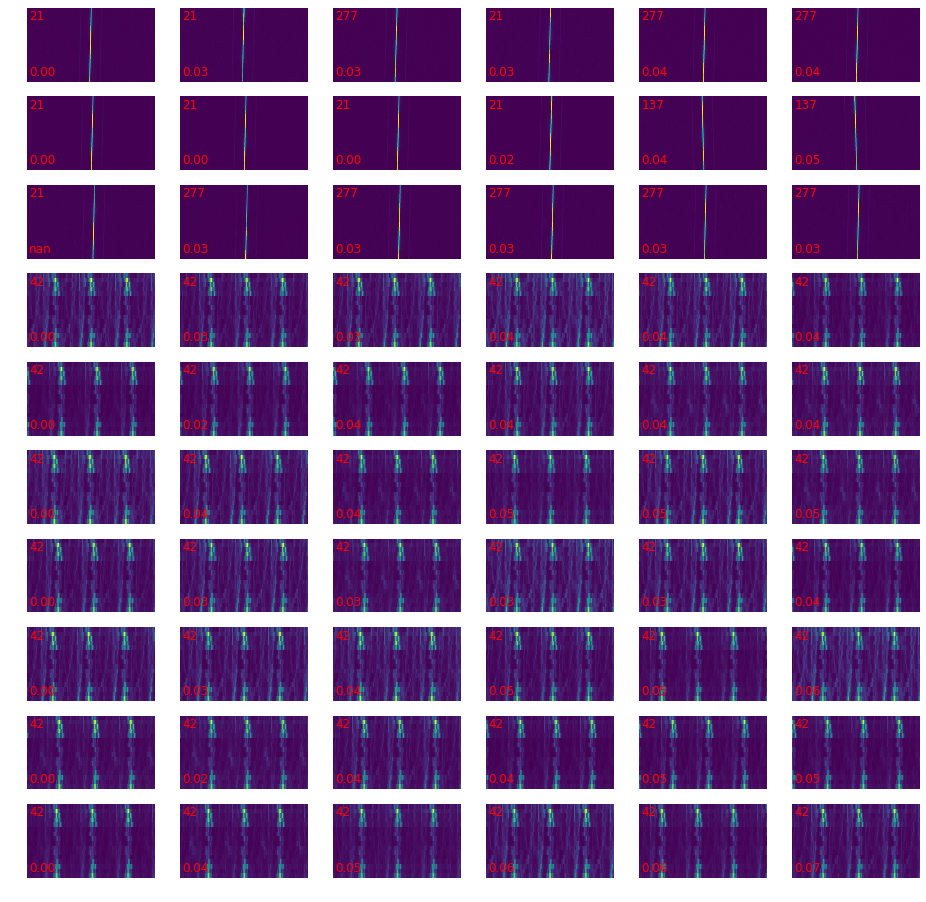

In [65]:
def plot_for_eval(z_, images, labs, k=5, plotsize=10, evalsize=500):
    f, ax = plt.subplots(plotsize, k+1, figsize=(16,16))
    out_ind = 0
    for z_ind, zz_ in enumerate(z_[:evalsize]):
        dots = np.sum(zz_[np.newaxis,...]*z_, axis=-1)
        dists = np.sqrt(2*(1-dots))
        inds = np.argsort(dots)[::-1]
        for j in range(k+1):
            ax[z_ind%plotsize,j].cla()
            ax[z_ind%plotsize,j].imshow(images[inds[j]], aspect='auto')
            ax[z_ind%plotsize,j].text(2,2,str(labs[inds[j]]), color='r', fontsize=12)
            ax[z_ind%plotsize,j].text(2,14,"{0:.2f}".format(dists[inds[j]]), color='r', fontsize=12)
            ax[z_ind%plotsize,j].axis('off')
        if z_ind%plotsize==0 and z_ind >0:
            plt.savefig("./models/new_model/noise_{}.png".format(out_ind))
            out_ind += 1

plot_for_eval(z_, test_data.squeeze(), coarse_chan, k=5, plotsize=10)
        

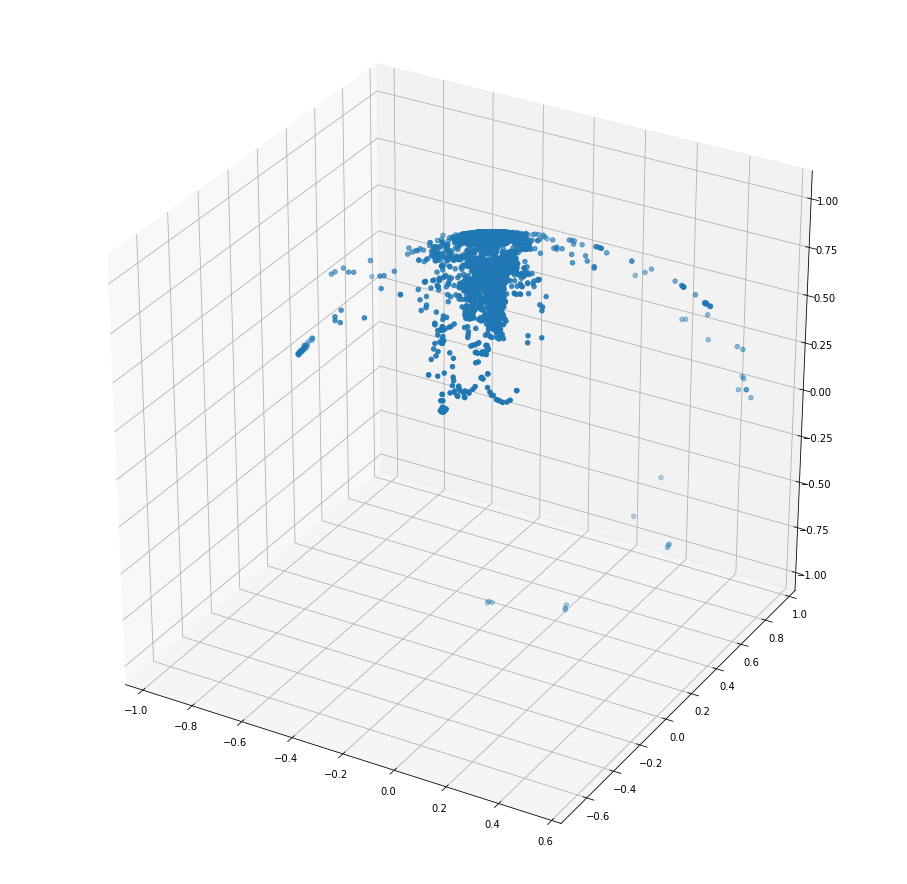

In [33]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_[:,0],z_[:,1],z_[:,2])
plt.show()
                        

In [12]:
import sklearn.mixture as mix
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering
GMM = mix.GaussianMixture(n_components=10)
#DB = DBSCAN(eps=20, min_samples=5)
#z_labels = DB.fit_predict(z_)
#spec = SpectralClustering(n_clusters=10)
GMM.fit(z_)
z_labels = GMM.predict(z_)
# z_labels = GMM.fit_predict(z_)

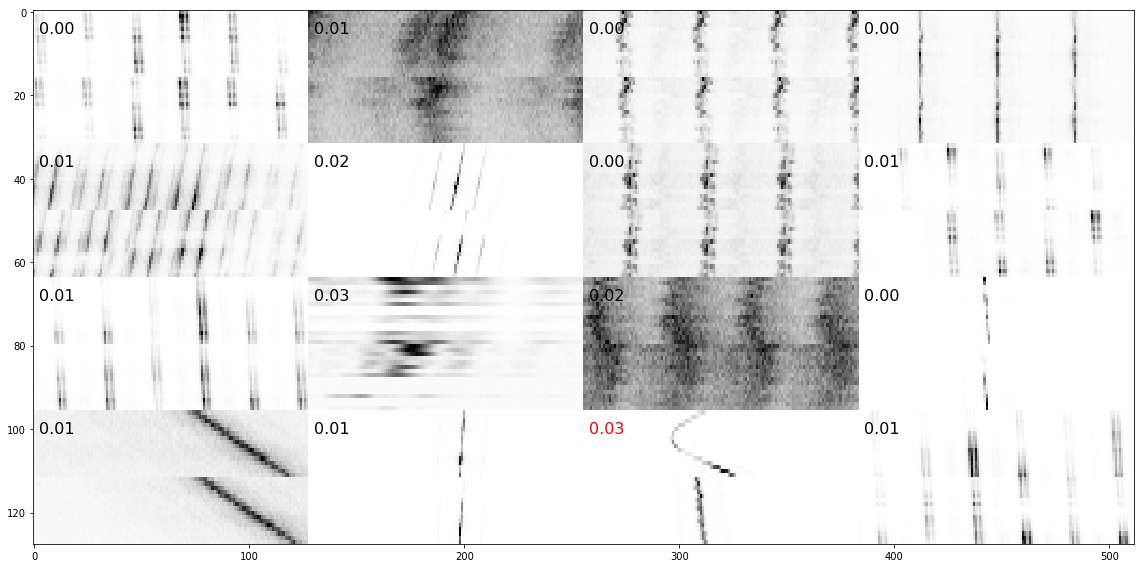

In [65]:
import matplotlib.patches as patches
def find_closest(model, image, stock):
    # Test the trained model: transformation
    #assert model_2d.n_z == 2
    z_, images = stock
    batch = datasess.run([image,label])
    z = model.transformer(batch[0])
    z = z[:,np.newaxis,:]
    z_ = z_[np.newaxis,...]
    temp = np.sum(z * z_,axis=-1)
    best_matches = np.argmax(temp, axis=1) 
    match_dist = 1 - np.amax(temp, axis=1)
    return batch[0], (best_matches, match_dist)
def show_comp(imgs, imgs_, dists, n=4,m=4):
    h, w = imgs.shape[1:3]
    f, ax = plt.subplots(figsize=(16, 8))
    canvas = np.empty((h*2*n, w*m))
    anomalies = []
    for i in range(n):
        for j in range(m):
            x = np.vstack([imgs[i*m+j], imgs_[i*m+j]]).squeeze()
            canvas[2*i*h:2*(i+1)*h, j*w:(j+1)*w] = x
            dist = dists[i*m+j]
            if dist > 0.03:
                c = 'r'
            else:
                c = 'black'
            ax.text(j*w+2, i*h*2+5, "{0:.2f}".format(dist), fontsize=16, color=c)
    
    f.set_tight_layout(True)
    ax.imshow(-canvas, aspect='auto', cmap='gray')
    #plt.savefig('/home/yunfanz/Projects/presentations/match.jpg')
    plt.show()
images_, matches = find_closest(model, image, (z_, images))
show_comp(images_[:16], images[matches[0][:16]], matches[1][:16])

In [58]:
plt.text?

/home/yunfanz/miniconda3/envs/TF3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


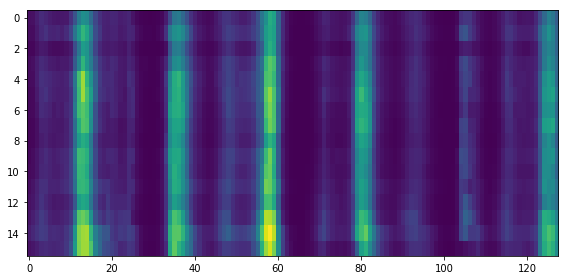

In [66]:
from matplotlib.animation import FuncAnimation
def make_animation(zs, model, save=True, name='explore.gif'):
    fig, ax = plt.subplots(figsize=(8,4))
    fig.set_tight_layout(True)
    x_hat = model.generator(zs).reshape((-1,16,128))
    img = ax.imshow(x_hat[0], aspect='auto')
    def update(i):
        img.set_data(x_hat[i])
        return img
    anim = FuncAnimation(fig, update, frames=np.arange(zs.shape[0]), interval=100)
    if save:
        savepath = '/home/yunfanz/Projects/presentations/'+name
        anim.save(savepath, dpi=80, writer='imagemagick')
    return anim
def expand_z(zs,n=10):
    zs = np.asarray(zs)
    nz, dim = zs.shape
    zout = np.empty((nz-1, n, dim))
    alpha = np.linspace(0,1,n)[:,np.newaxis]
    for i in range(nz-1):
        z1 = zs[i]; z2 = zs[i+1]
        ztemp = z1[np.newaxis, :]*alpha + z2[np.newaxis, :]*(1-alpha)
        zout[i] = ztemp
    zout = zout.reshape(((nz-1)*n, dim))
    return zout
inds = np.random.randint(low=0, high=2048, size=20)
ZS = expand_z(z_[inds], n=10)
make_animation(ZS, model, name='explore.gif')
    

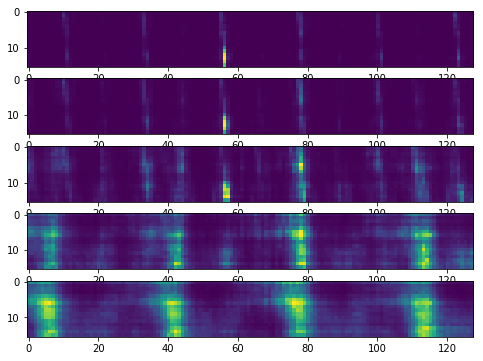

In [40]:


def test_generation(z1, z2, model, n=5):
    alpha = np.linspace(0,1,n)[:,np.newaxis]
    zs = z1[np.newaxis, :]*alpha + z2[np.newaxis, :]*(1-alpha)
    x_hat = model.generator(zs).reshape((-1,16,128))
    f, ax = plt.subplots(n,1, figsize=(8,6))
    for i in range(n):
        ax[i].imshow(x_hat[i], aspect='auto')
    plt.show()
    return zs
_ = test_generation(z_[1], z_[8], model)

In [70]:
zz, cc, inds = separate_labels(z, c)
colors = bokeh.palettes.inferno(len(cc))
legend = 'label'
tooltips = [("p", "(@x, @y)"),("label", "@label"),("index", "@index")]

hover_tsne = HoverTool(tooltips = tooltips) 
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset','box_zoom','save']
p = figure(plot_width=900, plot_height=500, tools=tools_tsne)
output_notebook()

for i in range(len(zz)):
    tsne_ = zz[i]
    labels_ = cc[i]
    indices_ = inds[i]
    labl = labels_[0]

    source_train = ColumnDataSource(
        data=dict(
            x = tsne_[:,0],
            y = tsne_[:,1],
            index = indices_,
            label = labels_
        )
    )
    

    if True:
        p.circle('x', 'y', size=7, fill_color=colors[i], 
                 alpha=0.9, line_width=0, source=source_train, name="test", legend=legend)
    else:
        p.diamond('x', 'y', size=7, #fill_color=BOOKEH_COLORS[labl], 
                 alpha=0.9, line_width=0, source=source_train, name="test", legend=legend)

p.legend.click_policy="hide"

show(p)

Loading BokehJS ...

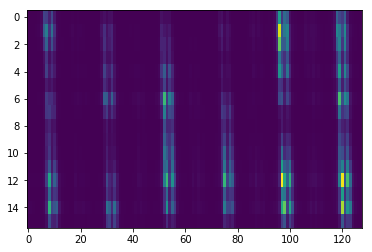

In [106]:
ind = 251
plt.figure()
plt.imshow(images[ind].squeeze(), aspect='auto')
plt.show()

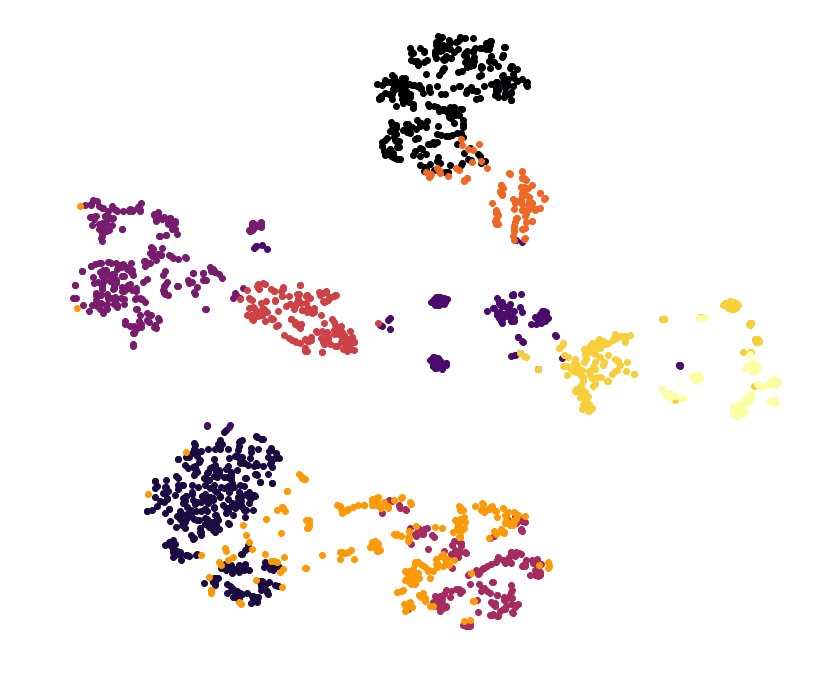

In [15]:
zz, cc, inds = separate_labels(z, z_labels)
colors = bokeh.palettes.inferno(len(cc))
plt.figure(figsize=(14, 12))
for i, c in enumerate(cc):
    ztemp = zz[i].T
    plt.scatter(ztemp[0], ztemp[1], color=colors[i])
    plt.axis('off')
#plt.savefig('/home/yunfanz/Projects/presentations/tsne.jpg')
plt.show()

In [12]:
z_.shape

(1024, 32)

In [30]:
# from visualize_embedding import *
from tensorflow.contrib.tensorboard.plugins import projector
import shutil, pathlib, os
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def convert_to_square(images, size=64):
    """Reshapes normal mnist digit (batch,16,128) to matrix (batch,32,32)"""
    images = np.reshape(images,(-1,16,128,1))
    nimgs = images.shape[0]
    tf.reset_default_graph()
    inp = tf.placeholder(dtype=tf.float32, shape=images.shape, name='input')
    boxes = tf.constant([[0,0.25,1,0.75]]*nimgs, dtype=tf.float32)
    box_ind = tf.constant(np.arange(nimgs), dtype=tf.int32)
    sizes = tf.constant([size,size], dtype=tf.int32)
    crops = tf.image.crop_and_resize(inp, boxes, box_ind=box_ind, crop_size=sizes)
    with tf.Session() as sess:
        output = sess.run(crops, feed_dict={inp:images})
    return output.squeeze()

def invert_grayscale(mnist_digits):
    """ Makes black white, and white black """
    return 1-mnist_digits



def create_visualization(embs, imgs, labs, eval_dir, sprite_path="sprite.png"):
    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.INFO)

    eval_size = embs.shape[0]
    #nlabels = np.unique(labs).size
    #labels_onehot = tf.one_hot(labs, nlabels)
    embedding_var = tf.Variable(embs, name='embedding')

    summary_writer = tf.summary.FileWriter(eval_dir)
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name

    # Specify where you find the sprite (we will create this later)
    # Copy the embedding sprite image to the eval directory
    #shutil.copy2(sprite_filename, eval_dir)
    
    embedding.sprite.image_path = pathlib.Path(sprite_path).name
    embedding.sprite.single_image_dim.extend([64, 64])

    # Specify where you find the metadata
    # Save the metadata file needed for Tensorboard projector
    metadata_filename = "metadata.tsv"
    with open(os.path.join(eval_dir, metadata_filename), 'w') as f:
        f.write("Index\tCoarse_channel\n")
        for index,label in enumerate(labs):
            f.write("%d\t%d\n" % (index,label))
    embedding.metadata_path = metadata_filename

    # Say that you want to visualise the embeddings
    projector.visualize_embeddings(summary_writer, config)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(embedding_var.initializer)
        saver.save(sess, os.path.join(eval_dir, "embeddings.ckpt"))


def visualize(embs, imgs, labs, model_dir='./models'):
    eval_dir = os.path.join(model_dir, "eval")
    if not os.path.exists(eval_dir):
        os.makedirs(eval_dir)
    sprite_path = os.path.join(eval_dir, "sprite.png")
    
    imgs = convert_to_square(imgs)
    imgs = invert_grayscale(imgs.squeeze())
    imgs = imgs.squeeze()
    sprite_img = create_sprite_image(imgs)
    plt.imsave(sprite_path,sprite_img, cmap='gray')
    
    create_visualization(embs, imgs, labs, eval_dir, sprite_path=sprite_path)

    print("running tensorboard at "+eval_dir)
    #sys.command("CUDA_VISIBLE_DEVICES='' tensorboard --logdir "+eval_dir)

    return
visualize(embs=z_, imgs=run_imgs, labs=coarse_chan, model_dir='./models/conv_noise/')


running tensorboard at ./models/conv_noise/eval


In [28]:
class VariantionalAutoencoder(object):

    def __init__(self, sess=None, input_tensor=None, learning_rate=1e-4, batch_size=64, n_z=16, loss_type='CE'):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build(loss_type=loss_type)

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self, loss_type='CE', lamb=1):
        self.input = tf.placeholder(
            name='input', dtype=tf.float32, shape=[None, 16, 128, 1])
        
        self.x = tf.layers.flatten(self.input, name='x')
        # Encode
        if True:
            f1 = conv2d(self.input, num_outputs=32, kernel_size=[3,3])
            m1 = max_pool2d(f1, kernel_size=[1,2], stride=[1,2])
            f2 = conv2d(m1, num_outputs=64, kernel_size=[3,3])
            m2 = max_pool2d(f2, kernel_size=2, stride=2)
            f3 = conv2d(m2, num_outputs=128, kernel_size=[3,3])
            m3 = max_pool2d(f3, kernel_size=[1,2], stride=[1,2])
            f4 = conv2d(m3, num_outputs=256, kernel_size=[3,3])
            m4 = max_pool2d(f4, kernel_size=2, stride=2)
            f5 = conv2d(m4, num_outputs=128, kernel_size=[3,3])
            m5 = max_pool2d(f5, kernel_size=[1,2], stride=[1,2])
            f6 = conv2d(m5, num_outputs=256, kernel_size=[3,3])
            m6 = max_pool2d(f6, kernel_size=2, stride=2)
            f7 = conv2d(m5, num_outputs=256, kernel_size=[3,3])
            ff = tf.layers.flatten(f7)
        else:
            # x -> z_mean, z_sigma -> z
            f1 = fc(self.x, 512, scope='enc_fc1', activation_fn=tf.nn.relu)
            f2 = fc(f1, 256, scope='enc_fc2', activation_fn=tf.nn.relu)
            ff = fc(f2, 128, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(ff, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(ff, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        # sample z from N(z_mu, sigma_squared)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 1024, scope='dec_fc1', activation_fn=tf.nn.relu)
        if True:
            g1 = tf.reshape(g1, [-1,1,8,128])
            g2 = conv2d_transpose(g1, num_outputs=64, kernel_size=2,stride=2)
            g2 = conv2d_transpose(g2, num_outputs=32, kernel_size=2,stride=2)
            g2 = conv2d_transpose(g2, num_outputs=16, kernel_size=3,stride=2)
            g3 = conv2d_transpose(g2, num_outputs=1, kernel_size=3,stride=2, activation_fn=tf.sigmoid)
            self.x_hat = tf.layers.flatten(g3)
        else:
            g2 = fc(g1, 256, scope='dec_fc2', activation_fn=tf.nn.relu)
            g3 = fc(g2, 512, scope='dec_fc3', activation_fn=tf.nn.relu)
            self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                            activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        if loss_type == 'CE':
            self.recon_loss = -tf.reduce_sum(
                self.x * tf.log(epsilon+self.x_hat) + 
                (1-self.x) * tf.log(epsilon+1-self.x_hat), 
                axis=1
            )
        elif loss_type == 'l2':
            self.recon_loss = tf.reduce_sum(
                tf.square(self.x -self.x_hat),
                axis=1
            )
        elif loss_type == 'l1':
            self.recon_loss = tf.reduce_sum(
                tf.abs(self.x -self.x_hat),
                axis=1
            )
        recon_loss = tf.reduce_mean(self.recon_loss)


        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution N(z_mu, sigma_squared) and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = recon_loss + self.latent_loss * lamb
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
#         for var in tf.global_variables():
#             print(var.name, var.get_shape())
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.input: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat, loss = self.sess.run([self.x_hat,self.recon_loss], feed_dict={self.input: x})
        return x_hat, loss

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.input: x})
        return z

In [76]:
# Train a model
model_vae = trainer(VariantionalAutoencoder, image, n_z=64, num_epoch=50, loss_type='l2')

[Epoch 0] recon_loss: 29.046  latent_loss: 4.084  total_loss: 33.130  (32.330 sec/epoch)
[Epoch 5] recon_loss: 18.331  latent_loss: 1.907  total_loss: 20.239  (31.314 sec/epoch)
[Epoch 10] recon_loss: 16.013  latent_loss: 1.953  total_loss: 17.967  (31.542 sec/epoch)
[Epoch 15] recon_loss: 16.563  latent_loss: 3.110  total_loss: 19.673  (33.233 sec/epoch)
[Epoch 20] recon_loss: 14.857  latent_loss: 2.327  total_loss: 17.184  (32.104 sec/epoch)
[Epoch 25] recon_loss: 13.421  latent_loss: 2.548  total_loss: 15.970  (32.197 sec/epoch)
[Epoch 30] recon_loss: 14.299  latent_loss: 3.154  total_loss: 17.453  (31.862 sec/epoch)
[Epoch 35] recon_loss: 16.451  latent_loss: 2.932  total_loss: 19.383  (31.852 sec/epoch)
[Epoch 40] recon_loss: 15.467  latent_loss: 2.634  total_loss: 18.101  (31.883 sec/epoch)
[Epoch 45] recon_loss: 10.453  latent_loss: 2.227  total_loss: 12.680  (32.690 sec/epoch)
Done!


[16.261436 13.06577  46.21502  13.977541]
[ 9.352119  11.651358  10.945824   4.2867365]
[18.249174   4.8729563 20.097553  12.595576 ]
[ 8.638965  15.17518    6.5026827 14.224636 ]


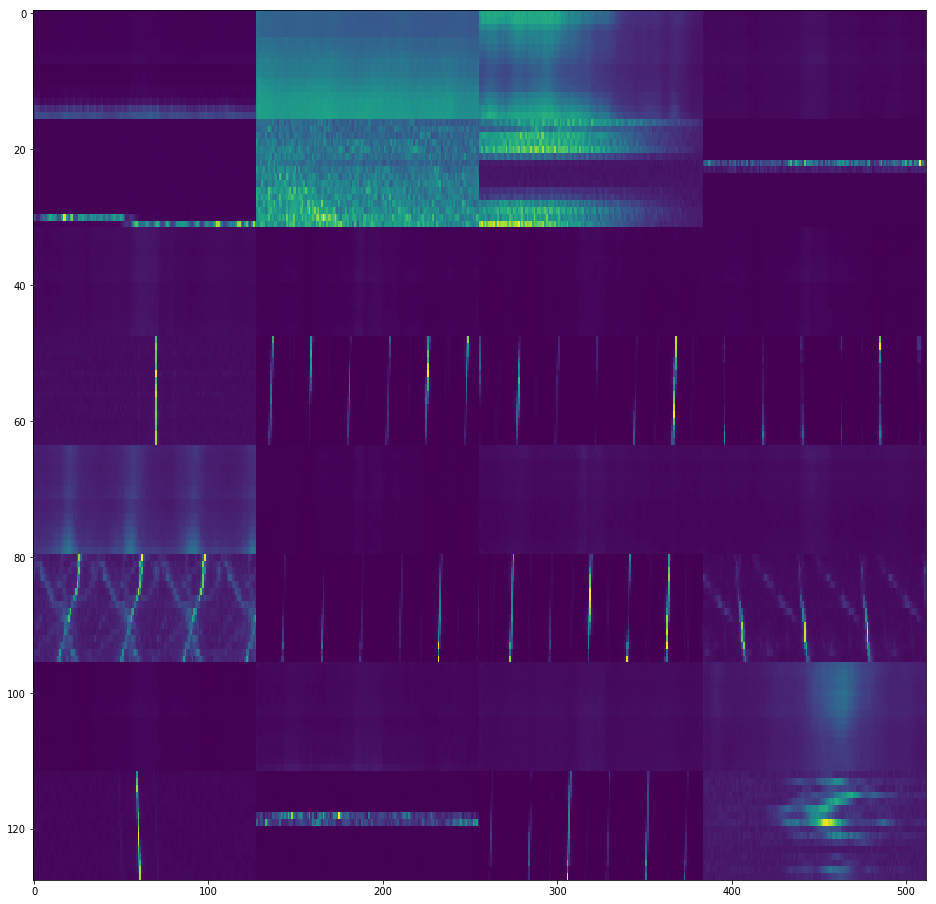

In [77]:
losses = test_reconstruction(model_vae, image)

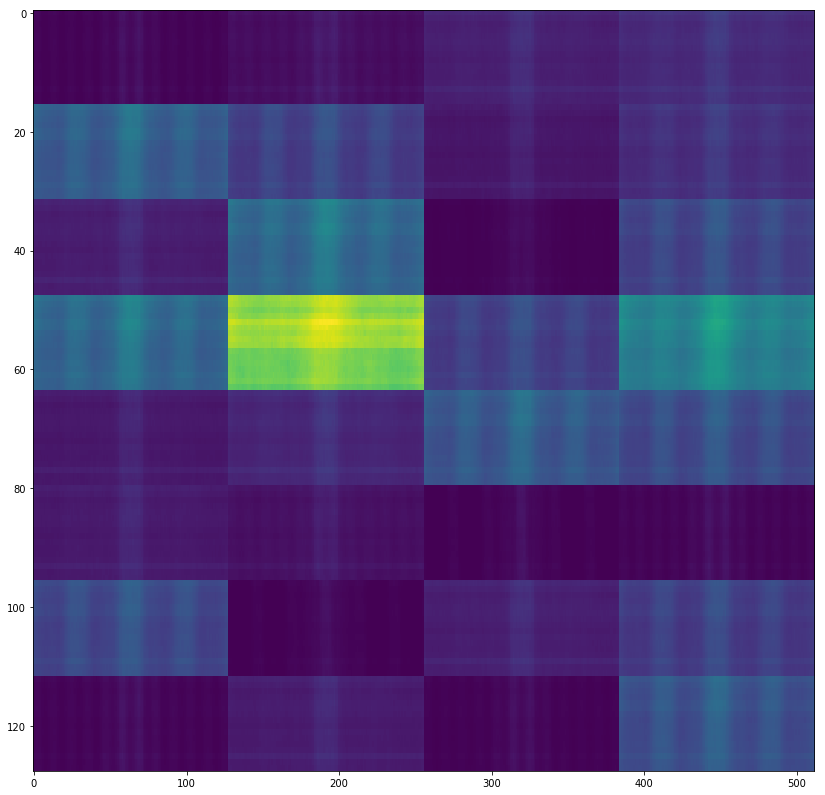

In [36]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model_vae.batch_size, model_vae.n_z])
x_generated = model_vae.generator(z)

n = 8; m = 4
#n = np.sqrt(model_vae.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*m))
for i in range(n):
    for j in range(m):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*m+j, :].reshape(h, w)

plt.figure(figsize=(14, 14))
plt.imshow(I_generated, aspect='auto')

In [ ]:
# Train a model with 2d latent space
model_2d = trainer(VariantionalAutoencoder, n_z=2)

[Epoch 0] recon_loss: 190.694  latent_loss: 4.371  total_loss: 195.066  (2.639 sec/epoch)
[Epoch 5] recon_loss: 166.146  latent_loss: 4.592  total_loss: 170.738  (2.500 sec/epoch)
[Epoch 10] recon_loss: 158.069  latent_loss: 5.256  total_loss: 163.325  (2.341 sec/epoch)
[Epoch 15] recon_loss: 149.287  latent_loss: 5.330  total_loss: 154.617  (2.532 sec/epoch)
[Epoch 20] recon_loss: 143.978  latent_loss: 5.783  total_loss: 149.760  (2.399 sec/epoch)
[Epoch 25] recon_loss: 134.043  latent_loss: 5.929  total_loss: 139.972  (2.601 sec/epoch)
[Epoch 30] recon_loss: 137.577  latent_loss: 5.793  total_loss: 143.370  (2.599 sec/epoch)
[Epoch 35] recon_loss: 134.183  latent_loss: 6.204  total_loss: 140.387  (2.368 sec/epoch)
[Epoch 40] recon_loss: 147.573  latent_loss: 6.086  total_loss: 153.659  (2.360 sec/epoch)
[Epoch 45] recon_loss: 129.339  latent_loss: 6.224  total_loss: 135.563  (2.518 sec/epoch)
[Epoch 50] recon_loss: 135.029  latent_loss: 6.251  total_loss: 141.280  (2.663 sec/epoch)
[

In [ ]:
test_transformation(model_2d, mnist)

In [ ]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")

# k-shot recognition

In [ ]:
embeddings = []
batch_id= 0
datasess.run(testset.iterator.initializer)
while True:
    try:
        d, lab = datasess.run([image_t, label_t])
        emb = model_.transformer(d)
        embeddings.append(emb)
        batch_id += 1
        if batch_id % 100 == 0:
            print(batch_id)
    except tf.errors.OutOfRangeError:
        embeddings = np.vstack(embeddings)
        break

In [100]:
np.save("./models/new_model/embedding_part3.npy", embeddings)

In [101]:
def get_adjac(em):
    return np.sum(em[np.newaxis,:,:]*em[:,np.newaxis,:], axis=-1)
from time import time
t0 = time()
a = get_adjac(embeddings[:10000])
t1 = time()
print("Estimate for total time: {}".format((t1-t0)*471.9**2))

Estimate for total time: 1828604.9388512706


In [139]:
tar = 94341
i = 0
filename = "./part3.tfrecords"
maxx = np.amax(list(dic.keys()))
for serialized_example in tf.python_io.tf_record_iterator(filename):
    if not i in dic:
        i += 1
        if i % 200000 == 0:
            print(i)
        if i > maxx:
            break
        else:
            continue
    else:
        example = tf.train.Example()
        keys_to_features = {'image_raw': tf.FixedLenFeature([], tf.string),
                            "coarse_channel": tf.FixedLenFeature([], tf.int64)}

        # Load one example
        parsed_features = tf.parse_single_example(serialized_example, keys_to_features)

        # Turn your saved image string into an array
        parsed_features['image_raw'] = tf.decode_raw(
            parsed_features['image_raw'], tf.float32)


        data = datasess.run(parsed_features['image_raw']).reshape(16,128)
        dic[i].append(data)
        i += 1
        
        

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000


In [123]:
gg_ = datasess.run(data).reshape(16,128)

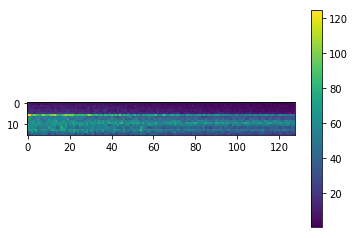

In [124]:
plt.imshow(gg_)
plt.colorbar()
plt.show()

In [160]:
means5 = [(1158034, 0.27054697),
 (2794969, 0.23690721),
 (4374271, 0.2350119),
 (4149521, 0.2186211),
 (4420711, 0.21678936),
 (4387208, 0.21138565),
 (94341, 0.21077378),
 (3981053, 0.20847876),
 (4320549, 0.20727997),
 (94464, 0.2070599)]
means1 = [(4149521, 0.2024048),
 (1158034, 0.18668666),
 (4320549, 0.18570806),
 (4617711, 0.18460809),
 (546304, 0.18347196),
 (2794969, 0.18297261),
 (1498774, 0.18285106),
 (4280962, 0.18228266),
 (3907760, 0.1812576),
 (94341, 0.17913768),
 (3842549, 0.17694992),
 (3555601, 0.17626311),
 (2789707, 0.17533104),
 (545775, 0.17495908),
 (94464, 0.1747873),
 (3868531, 0.17476411),
 (793377, 0.17402929),
 (4600680, 0.17357145),
 (1941235, 0.17317781),
 (3146782, 0.17235602),
 (4145486, 0.17125139),
 (3981053, 0.17006949),
 (2400627, 0.16990784),
 (3373644, 0.16987382),
 (4241862, 0.16983487),
 (4005879, 0.16953593),
 (4093495, 0.16952679),
 (1875846, 0.16936393),
 (1996209, 0.16923472),
 (3222547, 0.16883767),
 (1453571, 0.16791658),
 (1458104, 0.1674431),
 (4558949, 0.16733022),
 (4187351, 0.16685578),
 (922252, 0.16683292),
 (554423, 0.16665311),
 (4280932, 0.16646166),
 (4070822, 0.16607557),
 (3976601, 0.16576771),
 (4211988, 0.16509503),
 (4016279, 0.16501595),
 (3146745, 0.16490176),
 (4062818, 0.1648996),
 (4686439, 0.1645421),
 (545909, 0.16441634),
 (2971839, 0.16436122),
 (1091860, 0.16411409),
 (4387116, 0.16349149),
 (4597636, 0.16257016),
 (4052594, 0.16249572),
 (4537135, 0.16236766),
 (1127861, 0.16236398),
 (2608259, 0.16216598),
 (4146213, 0.16160412),
 (473490, 0.16155396),
 (480166, 0.16148975),
 (1535098, 0.16139671),
 (1299652, 0.16093479),
 (3976350, 0.16091256),
 (2874874, 0.1608607),
 (3355449, 0.16079955),
 (4594879, 0.16078584),
 (4137541, 0.1605614),
 (2248481, 0.16002557),
 (2510091, 0.16001514),
 (2205977, 0.15986495),
 (1835857, 0.15984854),
 (570148, 0.15948644),
 (569035, 0.1594442),
 (2884012, 0.15939373),
 (4328457, 0.15897211),
 (506779, 0.15895073),
 (4149509, 0.15855613),
 (3960384, 0.15828599),
 (3734863, 0.15819408),
 (1816050, 0.15804593),
 (94418, 0.15755944),
 (2432071, 0.15740654),
 (3589558, 0.15711166),
 (1554662, 0.15703538),
 (4594717, 0.15701792),
 (3746690, 0.15693134),
 (1793524, 0.1568565),
 (1446497, 0.15681621),
 (3911703, 0.15655297),
 (1974332, 0.15649585),
 (4331374, 0.15643986),
 (2226618, 0.15641814),
 (506821, 0.15640366),
 (4338491, 0.1562336),
 (2386168, 0.15617484),
 (531136, 0.15613896),
 (4264314, 0.15611605),
 (3620013, 0.15608473),
 (2911640, 0.15584129),
 (182207, 0.15579042),
 (4609940, 0.15579042),
 (4397382, 0.15567176),
 (325895, 0.15557066),
 (1458052, 0.15554152)]
#dic = {}
for key, val in means1:
    if key in dic:
        dic[key][0] = val
# for key, val in means5:
#     if key in dic:
#         dic[key].append(val)
#     else:
#         dic[key] = [None, val]
print(dic)

{4149521: [0.2024048, 0.2186211, array([[ 22.09953  ,  20.311853 ,  15.5034895, ...,   1.3017801,
          1.9484676,   1.946164 ],
       [ 17.670446 ,  24.808582 ,  18.28502  , ...,   2.0172293,
          1.214251 ,   2.5563734],
       [ 20.467012 ,  24.489468 ,  19.024557 , ...,   2.4202416,
          1.7694248,   0.3578949],
       ...,
       [ 19.75518  ,  16.13614  ,  16.639627 , ...,   2.1552484,
          2.8617096,   3.6592293],
       [155.01605  , 153.52977  , 136.28632  , ...,  16.766674 ,
         13.217863 ,  21.561209 ],
       [111.29498  , 100.49942  ,  95.596344 , ...,   9.859267 ,
         14.755833 ,  20.368282 ]], dtype=float32)], 1158034: [0.18668666, 0.27054697, array([[ inf,  inf,  inf, ...,  inf,  inf,  inf],
       [ inf,  inf,  inf, ...,  inf,  inf,  inf],
       [ inf,  inf,  inf, ...,  inf,  inf, -inf],
       ...,
       [ inf,  inf,  inf, ...,  inf,  inf,  inf],
       [ inf,  inf,  inf, ...,  inf,  inf,  inf],
       [ inf,  inf,  inf, ...,  inf,  inf

In [141]:
for k, v in dic.items():
    print(k, len(v))

4149521 3
1158034 3
4320549 3
4617711 2
546304 2
2794969 3
1498774 2
4280962 2
3907760 2
94341 3
4374271 3
4420711 3
4387208 3
3981053 3
94464 3


10


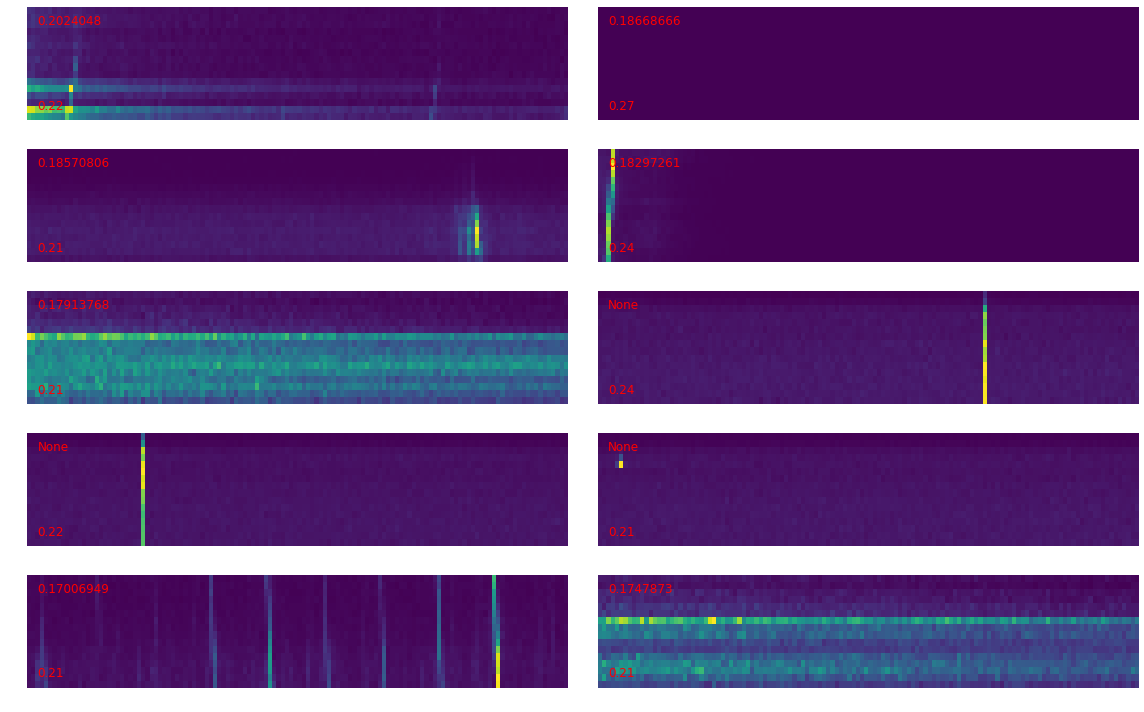

In [165]:
def plot_anom(anoms, m=5, n=2):
    ks = []
    for k in anoms.keys():
        if len(anoms[k]) == 3:
            ks.append(k)
    print(len(ks))
    f, ax = plt.subplots(m, n, figsize=(16,10))
    for i in range(m):
        for j in range(n):
            ind = i*n+j
            ax[i,j].cla()
            pimg = anoms[ks[ind]][2]
            if i==0 and j ==1 :
                pimg = np.zeros_like(pimg)
            ax[i,j].imshow(pimg, aspect='auto')
            ax[i,j].text(2,2,str(anoms[ks[ind]][0]), color='r', fontsize=12)
            ax[i,j].text(2,14,"{0:.2f}".format(anoms[ks[ind]][1]), color='r', fontsize=12)
            ax[i,j].axis('off')
    plt.tight_layout()
    plt.savefig("/home/yunfanz/Projects/presentations/anom.jpg")
    
    plt.show()
plot_anom(dic)

In [150]:
e1 = embeddings[4149521]
e2 = model_.transformer(dic[4149521][2].reshape((1,16,128,1)))

In [155]:
np.allclose(e1,e1.squeeze())

True